In [1]:
import sys
import torch
from sumolib import checkBinary
import sys
import matplotlib.pyplot as plt
import os
from utils import *

if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))

sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Using device: " + str(device))

SUMO_HOME found
SUMO_HOME found
Using device: cuda


## Node Degrees Before Pruning

In [2]:
restart(dur=800, density=1.5)
max_action_spaces = []
total_actions = 0

total_missing_gain = 0
total_delay_gain = 0
step = 0


while shouldContinueSim():
    step += 1
    if step > 1100:
        close()
        break
    traci.simulationStep()
    if step < 400:
        continue
    ids = traci.vehicle.getIDList()
    connectivity = intervehicleConnectivity(800)
    # minus the diagonal
    action_spaces = connectivity.to("cpu") - torch.eye(connectivity.size(0))
    for i, vehicle in enumerate(ids):
        # get non-zero indices except the diagonal
        non_zero_indices = np.where(action_spaces[i] == 1)[0]
        max_action_spaces.append(len(non_zero_indices))

# print each action space's proportion
cumulative = 0
cumulative_list = []
prob_list = []
for i in list(set(sorted(max_action_spaces, reverse=True))):
    prob_list.append(max_action_spaces.count(i)/len(max_action_spaces))
    print(prob_list[-1])
    cumulative += max_action_spaces.count(i)/len(max_action_spaces)
    cumulative_list.append(cumulative)
    print(cumulative)

Success.
***Starting server on port 44283 ***
Loading net-file from './config/osm.net.xml.gz' ... done (104ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 1200.00
Reason: TraCI requested termination.
Performance: 
 Duration: 1.62s
 TraCI-Duration: 1.43s
 Real time factor: 739.827
 UPS: 26687.422935
Vehicles: 
 Inserted: 89
 Running: 20
 Waiting: 0
Statistics (avg of 69):
 RouteLength: 4361.15
 Speed: 9.49
 Duration: 469.64
 WaitingTime: 17.19
 TimeLoss: 65.58
 DepartDelay: 0.48

0.115543821909325
0.115543821909325
0.14552980672077181
0.2610736286300968
0.1493758352074574
0.4104494638375542
0.12476777158502005
0.5352172354225743
0.11081776995534695
0.6460350053779212
0.07962582705909195
0.7256608324370132
0.05009615071216714
0.7757569831491803
0.05941788077311691
0.8351748639222972
0.048825005703855805
0.8839998696261531
0.0365698640852645
0.9205697337114176
0.023499885922883868
0.9440696196343015
0.018089371272122814
0.9621589909064243
0.

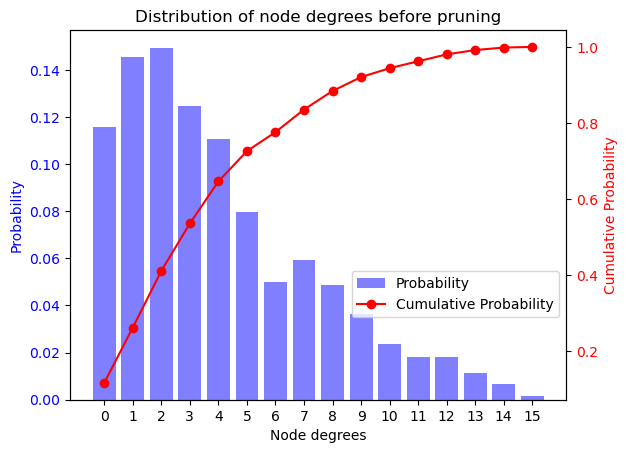

In [3]:
fig, ax1 = plt.subplots()

num_neighbour = [i for i in range(0, len(prob_list))]

ax1.bar(num_neighbour, prob_list, alpha=0.5, color='blue', label='Probability')
ax1.set_xlabel('Node degrees')

ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(num_neighbour)
# Step 4: Plot the cumulative probability curve
ax2 = ax1.twinx()
ax2.plot(num_neighbour, cumulative_list, color='red', marker='o', linestyle='-', label='Cumulative Probability')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_ylabel('Probability', color='blue')
ax2.set_ylabel('Cumulative Probability', color='red')
ax1.set_title('Distribution of node degrees before pruning')
fig.legend(loc=(0.56, 0.3))

plt.show()
# save as pdf
fig.savefig('before pruning.pdf', format='pdf', dpi=1200, bbox_inches='tight')

## Node Degrees After Pruning

In [4]:
restart(dur=800, density=1.5)
max_action_spaces = []
total_actions = 0

total_missing_gain = 0
total_delay_gain = 0
step = 0
max_num_nodes = 0


while shouldContinueSim():
    step += 1
    if step > 1100:
        close()
        break
    traci.simulationStep()
    if step < 400:
        continue
    adj_matrix = intervehicleConnectivity(800)
    adj_matrix = simplify_graph(adj_matrix)
    n_hop_matrix = bfs_distance(adj_matrix)
    # minus the diagonal
    adj_matrix = adj_matrix.to("cpu")
    
    for i in range(adj_matrix.size(0)):
        n_unreachable_nodes = len(torch.where(n_hop_matrix[i] == 100)[0])
        n_nodes = adj_matrix.size(0) - n_unreachable_nodes
        max_num_nodes = max(max_num_nodes, n_nodes)
        non_zero_indices = np.where(adj_matrix[i] == 1)[0]
        two_hop_neighbours = np.where(n_hop_matrix[i] == 2)[0]
        two_hop_neighbours_mask = (n_hop_matrix[i] == 2).type(torch.int)
        # direct neighbours connectivities with two hop neighbours
        neighbour_dict = {}
        for neighbour_index in non_zero_indices:
            neighbour_dict[neighbour_index] = two_hop_neighbours[np.where(adj_matrix[neighbour_index][two_hop_neighbours] == 1)[0]]
        # sort by the number of two hop neighbours
        neighbour_dict = dict(sorted(neighbour_dict.items(), key=lambda item: len(item[1]), reverse=True))
        
        action_space = 0
        to_remove_indices = []
        for neighbour_index, two_hop_neighbours_indices in neighbour_dict.items():
            mask_sum_before = torch.sum(two_hop_neighbours_mask)
            two_hop_neighbours_mask[two_hop_neighbours_indices] = 0
            mask_sum_after = torch.sum(two_hop_neighbours_mask)
            if mask_sum_after < mask_sum_before:
                action_space += 1
            else:
                to_remove_indices.append(neighbour_index)
        cur_adj_matrix = np.delete(adj_matrix, to_remove_indices, axis=0)
        cur_adj_matrix = np.delete(cur_adj_matrix, to_remove_indices, axis=1)
        max_action_spaces.append(action_space)

# print each action space's proportion
cumulative = 0
cumulative_list = []
prob_list = []
for i in list(set(sorted(max_action_spaces, reverse=True))):
    prob_list.append(max_action_spaces.count(i)/len(max_action_spaces))
    cumulative += max_action_spaces.count(i)/len(max_action_spaces)
    cumulative_list.append(cumulative)
print(max_num_nodes)

Success.
***Starting server on port 37785 ***
Loading net-file from './config/osm.net.xml.gz' ... done (107ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 1200.00
Reason: TraCI requested termination.
Performance: 
 Duration: 24.81s
 TraCI-Duration: 24.49s
 Real time factor: 48.3695
 UPS: 1744.810351
Vehicles: 
 Inserted: 89
 Running: 20
 Waiting: 0
Statistics (avg of 69):
 RouteLength: 4361.15
 Speed: 9.49
 Duration: 469.64
 WaitingTime: 17.19
 TimeLoss: 65.58
 DepartDelay: 0.48

43


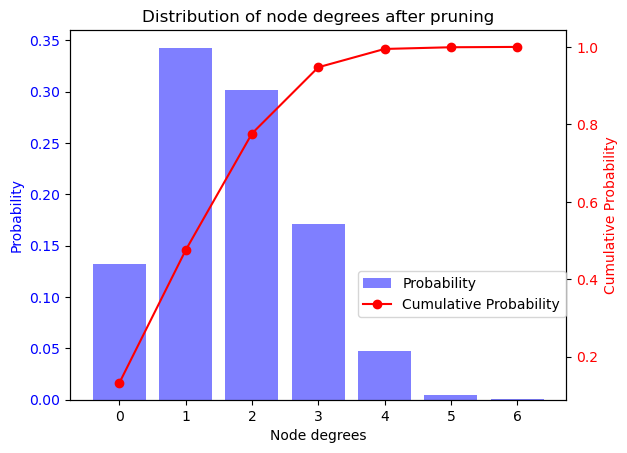

In [5]:
fig, ax1 = plt.subplots()

num_neighbour = [i for i in range(min(max_action_spaces), max(max_action_spaces)+1)]

ax1.bar(num_neighbour, prob_list, alpha=0.5, color='blue', label='Probability')
ax1.set_xlabel('Node degrees')

ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(num_neighbour)
# Step 4: Plot the cumulative probability curve
ax2 = ax1.twinx()
ax2.plot(num_neighbour, cumulative_list, color='red', marker='o', linestyle='-', label='Cumulative Probability')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_ylabel('Probability', color='blue')
ax2.set_ylabel('Cumulative Probability', color='red')
ax1.set_title('Distribution of node degrees after pruning')
fig.legend(loc=(0.57, 0.3))

plt.show()
# save as pdf
fig.savefig('after_pruning.pdf', format='pdf', dpi=1200, bbox_inches='tight')

## Node Degrees After Pruning and Padding

In [7]:
restart(dur=800, density=1.5)
max_action_spaces = []
total_actions = 0

total_missing_gain = 0
total_delay_gain = 0
step = 0
max_num_nodes = 0


while shouldContinueSim():
    step += 1
    if step > 1100:
        close()
        break
    traci.simulationStep()
    if step < 400:
        continue
    connectivity = intervehicleConnectivity(800)
    connectivity = simplify_graph(connectivity)
    # minus the diagonal
    action_spaces = connectivity.to("cpu")
    max_num_nodes = max(max_num_nodes, action_spaces.size(0))
    for i in range(action_spaces.size(0)):
        action_space = len(np.where(action_spaces[i] == 1)[0])
        if action_space != 1:
            if action_space >= 6:
                max_action_spaces.append(6)
            else:
                max_action_spaces.append(action_space)

# print each action space's proportion
cumulative = 0
cumulative_list = []
prob_list = []
for i in list(set(sorted(max_action_spaces, reverse=True))):
    prob_list.append(max_action_spaces.count(i)/len(max_action_spaces))
    cumulative += max_action_spaces.count(i)/len(max_action_spaces)
    cumulative_list.append(cumulative)

Success.
***Starting server on port 47727 ***
Loading net-file from './config/osm.net.xml.gz' ... done (105ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 1200.00
Reason: TraCI requested termination.
Performance: 
 Duration: 1.51s
 TraCI-Duration: 1.31s
 Real time factor: 795.756
 UPS: 28704.907162
Vehicles: 
 Inserted: 89
 Running: 20
 Waiting: 0
Statistics (avg of 69):
 RouteLength: 4361.15
 Speed: 9.49
 Duration: 469.64
 WaitingTime: 17.19
 TimeLoss: 65.58
 DepartDelay: 0.48



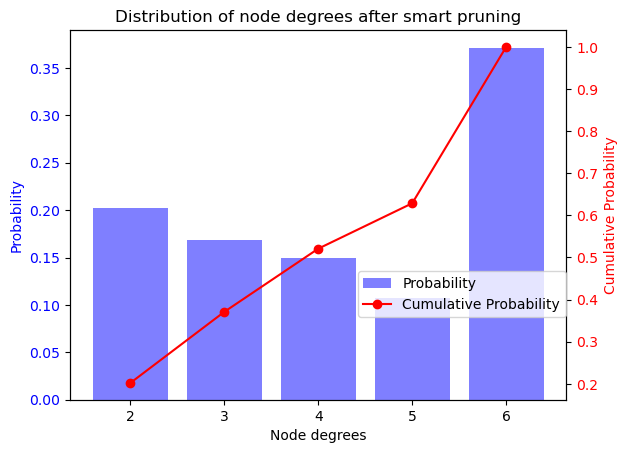

In [8]:
fig, ax1 = plt.subplots()

num_neighbour = [i for i in range(min(max_action_spaces), max(max_action_spaces)+1)]

ax1.bar(num_neighbour, prob_list, alpha=0.5, color='blue', label='Probability')
ax1.set_xlabel('Node degrees')

ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(num_neighbour)
# Step 4: Plot the cumulative probability curve
ax2 = ax1.twinx()
ax2.plot(num_neighbour, cumulative_list, color='red', marker='o', linestyle='-', label='Cumulative Probability')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_ylabel('Probability', color='blue')
ax2.set_ylabel('Cumulative Probability', color='red')
ax1.set_title('Distribution of node degrees after smart pruning')
fig.legend(loc=(0.57, 0.3))

plt.show()
# save as pdf
fig.savefig('after_smart_pruning.pdf', format='pdf', dpi=1200, bbox_inches='tight')

## Test

In [9]:
adj_matrix = torch.tensor([[1, 1, 0, 0, 1, 1, 0, 0],
                            [1, 1, 1, 0, 1, 1, 0, 0],
                            [0, 1, 1, 1, 0, 0, 1, 1],
                            [0, 0, 1, 1, 0, 0, 0, 0],
                            [1, 1, 0, 0, 1, 0, 1, 0],
                            [1, 1, 0, 0, 0, 1, 0, 0],
                            [0, 0, 1, 0, 1, 0, 1, 0],
                            [0, 0, 1, 0, 0, 0, 0, 1]])
action_spaces = simplify_graph(adj_matrix)
n_hop_matrix = bfs_distance(action_spaces)

max_action_spaces = []
for i in range(action_spaces.size(0)):
    non_zero_indices = np.where(action_spaces[i] == 1)[0]
    two_hop_neighbours = np.where(n_hop_matrix[i] == 2)[0]
    two_hop_neighbours_mask = (n_hop_matrix[i] == 2).type(torch.int)
    # direct neighbours connectivities with two hop neighbours
    neighbour_dict = {}
    for neighbour_index in non_zero_indices:
        neighbour_dict[neighbour_index] = two_hop_neighbours[np.where(adj_matrix[neighbour_index][two_hop_neighbours] == 1)[0]]
    # sort by the number of two hop neighbours
    neighbour_dict = dict(sorted(neighbour_dict.items(), key=lambda item: len(item[1]), reverse=True))
    action_space = 0
    to_remove_indices = []
    for neighbour_index, two_hop_neighbours_indices in neighbour_dict.items():
        mask_sum_before = torch.sum(two_hop_neighbours_mask)
        two_hop_neighbours_mask[two_hop_neighbours_indices] = 0
        mask_sum_after = torch.sum(two_hop_neighbours_mask)
        if mask_sum_after < mask_sum_before:
            action_space += 1
        else:
            to_remove_indices.append(neighbour_index)
    cur_adj_matrix = np.delete(adj_matrix, to_remove_indices, axis=0)
    cur_adj_matrix = np.delete(cur_adj_matrix, to_remove_indices, axis=1)
    print(action_space)
    print(cur_adj_matrix)
    # remove
    max_action_spaces.append(action_space)

2
tensor([[1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 0],
        [1, 1, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 1]])
1
tensor([[1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1]])
1
tensor([[1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 0, 0],
        [1, 1, 0, 1, 0],
        [1, 1, 0, 0, 1]])
1
tensor([[1, 1, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1]])
1
tensor([[1, 1, 0, 1, 1, 0],
        [1, 1, 1, 0, 0, 1],
        [0, 1, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 1]])
1
tensor([[1, 1, 0, 1, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 1],
        [0, 1,